In [15]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from music21 import converter
from tqdm import tqdm

In [2]:
# Funtion to extract the pitch histogram from a score
def extract_pitch_histogram(score):

    pitch_histogram = [0]*12

    try:

        all_notes = score.flat.notes    # Flatten the score
        total_pitches = 0

        for note in all_notes:

            if note.quarterLength < 0.05:   # For removing ornamental notes
                continue

            if note.isNote:     # for single note
                pitch_histogram[note.pitch.pitchClass] += 1
                total_pitches += 1

            elif note.isChord:      # for chord include all different pitches
                for pitch in note.pitches:
                    pitch_histogram[pitch.pitchClass] += 1
                    total_pitches += 1

        if total_pitches == 0:
            return None
        
        return [pitch_count/total_pitches for pitch_count in pitch_histogram]   # normalize to make data independent of score length
    
    except:
        return None

In [3]:
# Function to extract rhythm features from given score
def extract_rhythm_features(score,top_n=10):
    try:

        durations = {}  
        all_notes = score.flat.notes    # Flatten the score

        for note in all_notes:
            if note.quarterLength < 0.05:   # For removing ornamental notes
                continue

            duration = float(round(note.quarterLength,2))   
            durations[duration] = durations.get(duration,0) + 1

        sorted_durations = sorted(durations.items(),key = lambda x: -x[1])[:top_n]
        total = sum(dur[1] for dur in sorted_durations)

        features = []   # of the form [freq, dur, freq, dur ...]

        for dur, count in sorted_durations:
            freq = count/total
            features.extend([freq,dur])

        while len(features) < 2 * top_n:     # Fill zeros till length 2 * top_n
            features.extend([0.0,0.0])

        if not features:
            return None
        
        return features
    
    except:
        return None

In [4]:
# Function to extract interval histogram from given score
def extract_interval_histogram(score):  
    
    try:

        all_notes = score.flat.notes    # Flatten the score
        pitches = []

        for note in all_notes:
            if note.quarterLength < 0.05:   # For removing ornamental notes
                continue

            if note.isNote:
                pitches.append(note.pitch.midi)
            
            elif note.isChord:
                # Take melody line only (highest note of chord)
                pitches.append(max(pitch.midi for pitch in note.pitches))
        
        intervals = []

        for i in range(1,len(pitches)):
            interval = pitches[i] - pitches[i-1]
            # Skip intervals greater than octave
            if interval <= 12 and interval >= -12:
                intervals.append(interval)

        interval_histogram = [0]*25     # For -12 to +12 semitones

        for i in intervals:
            interval_histogram[i+12] += 1
        
        total = sum(interval_histogram)

        if total == 0:
            return None

        return [interval_count/total for interval_count in interval_histogram]      # normalize data


    except:
        return None

In [5]:
# Make combined vector from all three histograms/features
def extract_combined_features(score):

    pitch = extract_pitch_histogram(score)
    interval = extract_interval_histogram(score)
    rhythm = extract_rhythm_features(score)

    if pitch and rhythm and interval:
        return pitch + interval + rhythm

In [6]:
# Feature Labels
feature_labels = (
    ['Pitch_' + str(i) for i in range(12)] +
    ['Interval_' + str(i-12) for i in range(25)] +
    ['DurFreq_' + str(i//2) if i%2==0 else 'DurVal_' + str(i//2) for i in range(20)]
)

In [ ]:
# Load entire maestro dataset as pandas dataframe
csv_path = os.path.join("maestro-v3.0.0", "maestro-v3.0.0.csv")
df = pd.read_csv(csv_path)

In [ ]:
# Chosen composers
composers = ["Frédéric Chopin",         # Romantic Era
             "Ludwig van Beethoven",    # Classical Era
             "Johann Sebastian Bach"]   # Baroque Era

# Get files of only chosen composers
composer_df = df[df['canonical_composer'].isin(composers)].copy()   

# Count files for each composer
composer_counts = composer_df.value_counts('canonical_composer')

# Min number of files for a composer
min_files = composer_counts.min()

# Random sampling of min_files number of files for all composers
balanced_df = composer_df.groupby('canonical_composer').sample(n=min_files,random_state=42).reset_index(drop=True)

In [14]:
# Show final dataframe
balanced_df

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Frédéric Chopin,Etude Op. 25 No. 11,train,2015,2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-f...,2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-f...,210.821875
1,Frédéric Chopin,Ballade 4 Op. 52,train,2006,2006/MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MI...,2006/MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MI...,603.939033
2,Frédéric Chopin,"Ballade No. 3 in A-flat Major, Op. 47",train,2008,2008/MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MI...,2008/MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MI...,418.390340
3,Frédéric Chopin,"Scherzo No. 1 in B minor, Op. 20",validation,2013,2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_...,2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_...,555.191753
4,Frédéric Chopin,Nocturne Op. 27 No. 2 in D-flat Major,validation,2017,2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-...,2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-...,341.238713
...,...,...,...,...,...,...,...
430,Ludwig van Beethoven,"Sonata No. 24 in F-sharp Major, Op. 78, First ...",train,2008,2008/MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MI...,2008/MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MI...,278.421196
431,Ludwig van Beethoven,"Sonata No. 11 in E-flat Major, Op. 22 (Complete)",validation,2014,2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO...,2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO...,1320.414011
432,Ludwig van Beethoven,"Sonata No. 21, Op. 53, ""Waldstein"", I. Allegro...",train,2017,2017/MIDI-Unprocessed_062_PIANO062_MID--AUDIO-...,2017/MIDI-Unprocessed_062_PIANO062_MID--AUDIO-...,488.333077
433,Ludwig van Beethoven,"Sonata No. 7, Op. 10 No. 3 in D Major, I. Presto",train,2017,2017/MIDI-Unprocessed_067_PIANO067_MID--AUDIO-...,2017/MIDI-Unprocessed_067_PIANO067_MID--AUDIO-...,289.101148


In [ ]:
maestro_path = "maestro-v3.0.0"

features = []
labels = []

# Loop through each MIDI file entry
for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    midi_path = os.path.join(maestro_path, row["midi_filename"])
    
    try:
        # Load the MIDI file as a music21 score object
        score = converter.parse(midi_path)
        feature_vector = extract_combined_features(score)
        
        if feature_vector:
            features.append(feature_vector)
            labels.append((row["canonical_composer"].split())[-1])  # take only surnames of composers
    
    except Exception as e:
        print(f"Error in {midi_path}: {e}")

100%|██████████| 435/435 [10:53<00:00,  1.50s/it]


In [36]:
# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

In [37]:
# Check shape of arrays
print("Features shape:", features.shape)    # (num_samples, num_features)
print("Labels shape:", labels.shape)        # (num_samples,)

Features shape: (435, 57)
Labels shape: (435,)


In [38]:
# Encoding labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Print out the mapping
print("Label Mapping:")
for i, name in enumerate(le.classes_):
    print(f"{name} → {i}")

# Print out the label distribution
print("\nLabel distribution:")
for idx, label in enumerate(le.classes_):
    print(f"{label} (encoded as {idx}): {(labels_encoded == idx).sum()}")

Label Mapping:
Bach → 0
Beethoven → 1
Chopin → 2

Label distribution:
Bach (encoded as 0): 145
Beethoven (encoded as 1): 145
Chopin (encoded as 2): 145


In [39]:
# Train(60%) - Val(20%) - Test(20%) split

X_train, X_temp, y_train, y_temp = train_test_split(features, labels_encoded, test_size=0.4, stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print final sizes
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (261, 57) (261,)
Val:   (87, 57) (87,)
Test:  (87, 57) (87,)


In [40]:
# Define a Random Forest Classifier model
model = RandomForestClassifier(n_estimators=200, random_state=42)

# Train model on train set
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [41]:
# Validate
y_val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy:", val_acc)
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

Validation Accuracy: 0.9425287356321839

Validation Classification Report:
              precision    recall  f1-score   support

        Bach       0.97      1.00      0.98        29
   Beethoven       0.90      0.93      0.92        29
      Chopin       0.96      0.90      0.93        29

    accuracy                           0.94        87
   macro avg       0.94      0.94      0.94        87
weighted avg       0.94      0.94      0.94        87



In [42]:
# Final test
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Test Accuracy:", test_acc)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

Test Accuracy: 0.9655172413793104

Test Classification Report:
              precision    recall  f1-score   support

        Bach       0.97      0.97      0.97        29
   Beethoven       1.00      0.93      0.96        29
      Chopin       0.94      1.00      0.97        29

    accuracy                           0.97        87
   macro avg       0.97      0.97      0.97        87
weighted avg       0.97      0.97      0.97        87



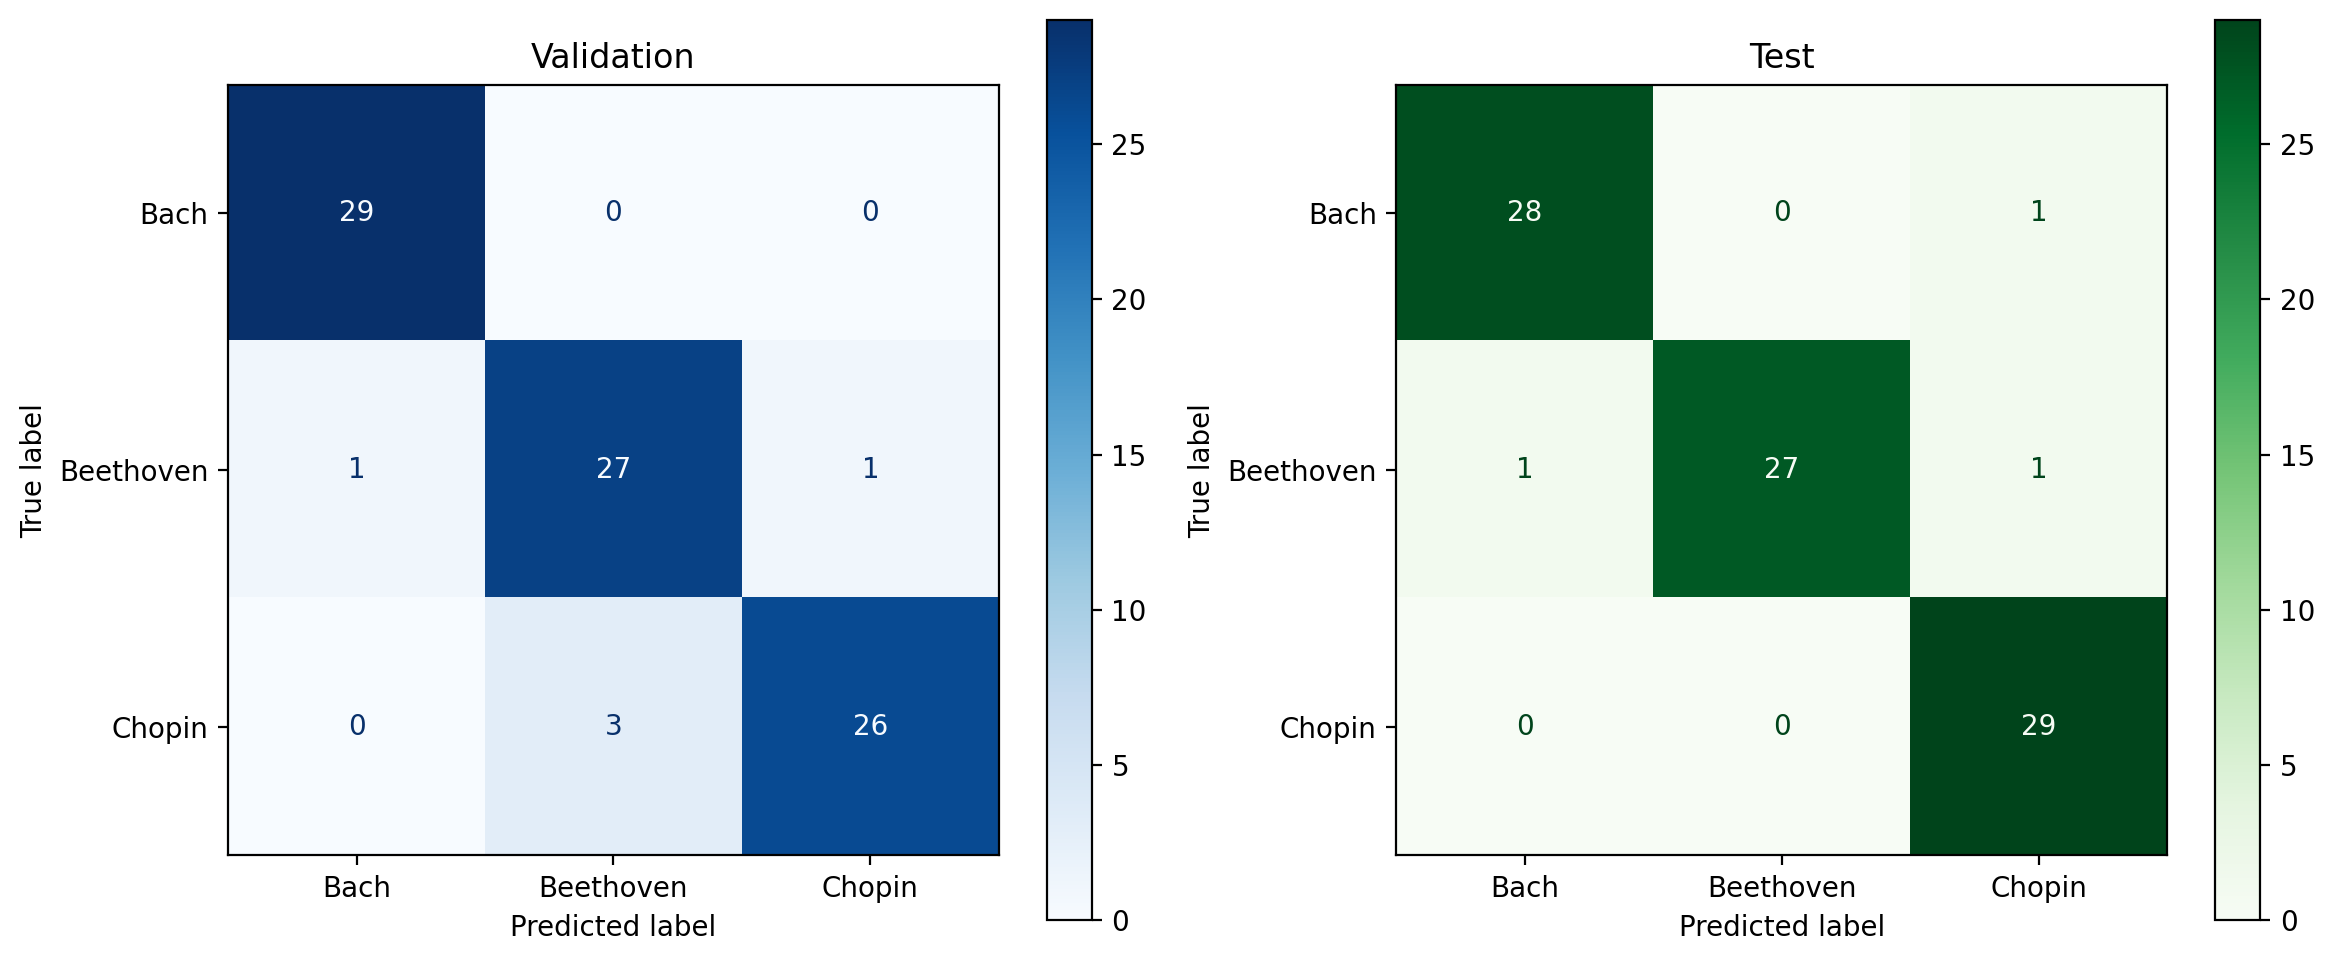

In [47]:
# Compute confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize = (12,5))

# Visualize confusion matrix for val
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Validation")

# Confusion matrix for test
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
disp_test.plot(ax=axes[1], cmap='Greens')
axes[1].set_title("Test")

plt.tight_layout()
plt.show()


In [56]:
# Feature importances
feature_importances = model.feature_importances_

# Create a dataframe
importance_df = pd.DataFrame({
    "Feature": feature_labels,
    "Importance": feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Show top 10 features
importance_df.head(10)

,Feature,Importance
0,Interval_0,0.101273
1,Interval_-12,0.056611
2,Interval_2,0.046547
3,DurFreq_1,0.042263
4,Interval_-10,0.037610
5,Interval_-1,0.033038
6,Interval_12,0.032114
7,Interval_-3,0.031838
8,Interval_10,0.029041
9,Pitch_2,0.028425


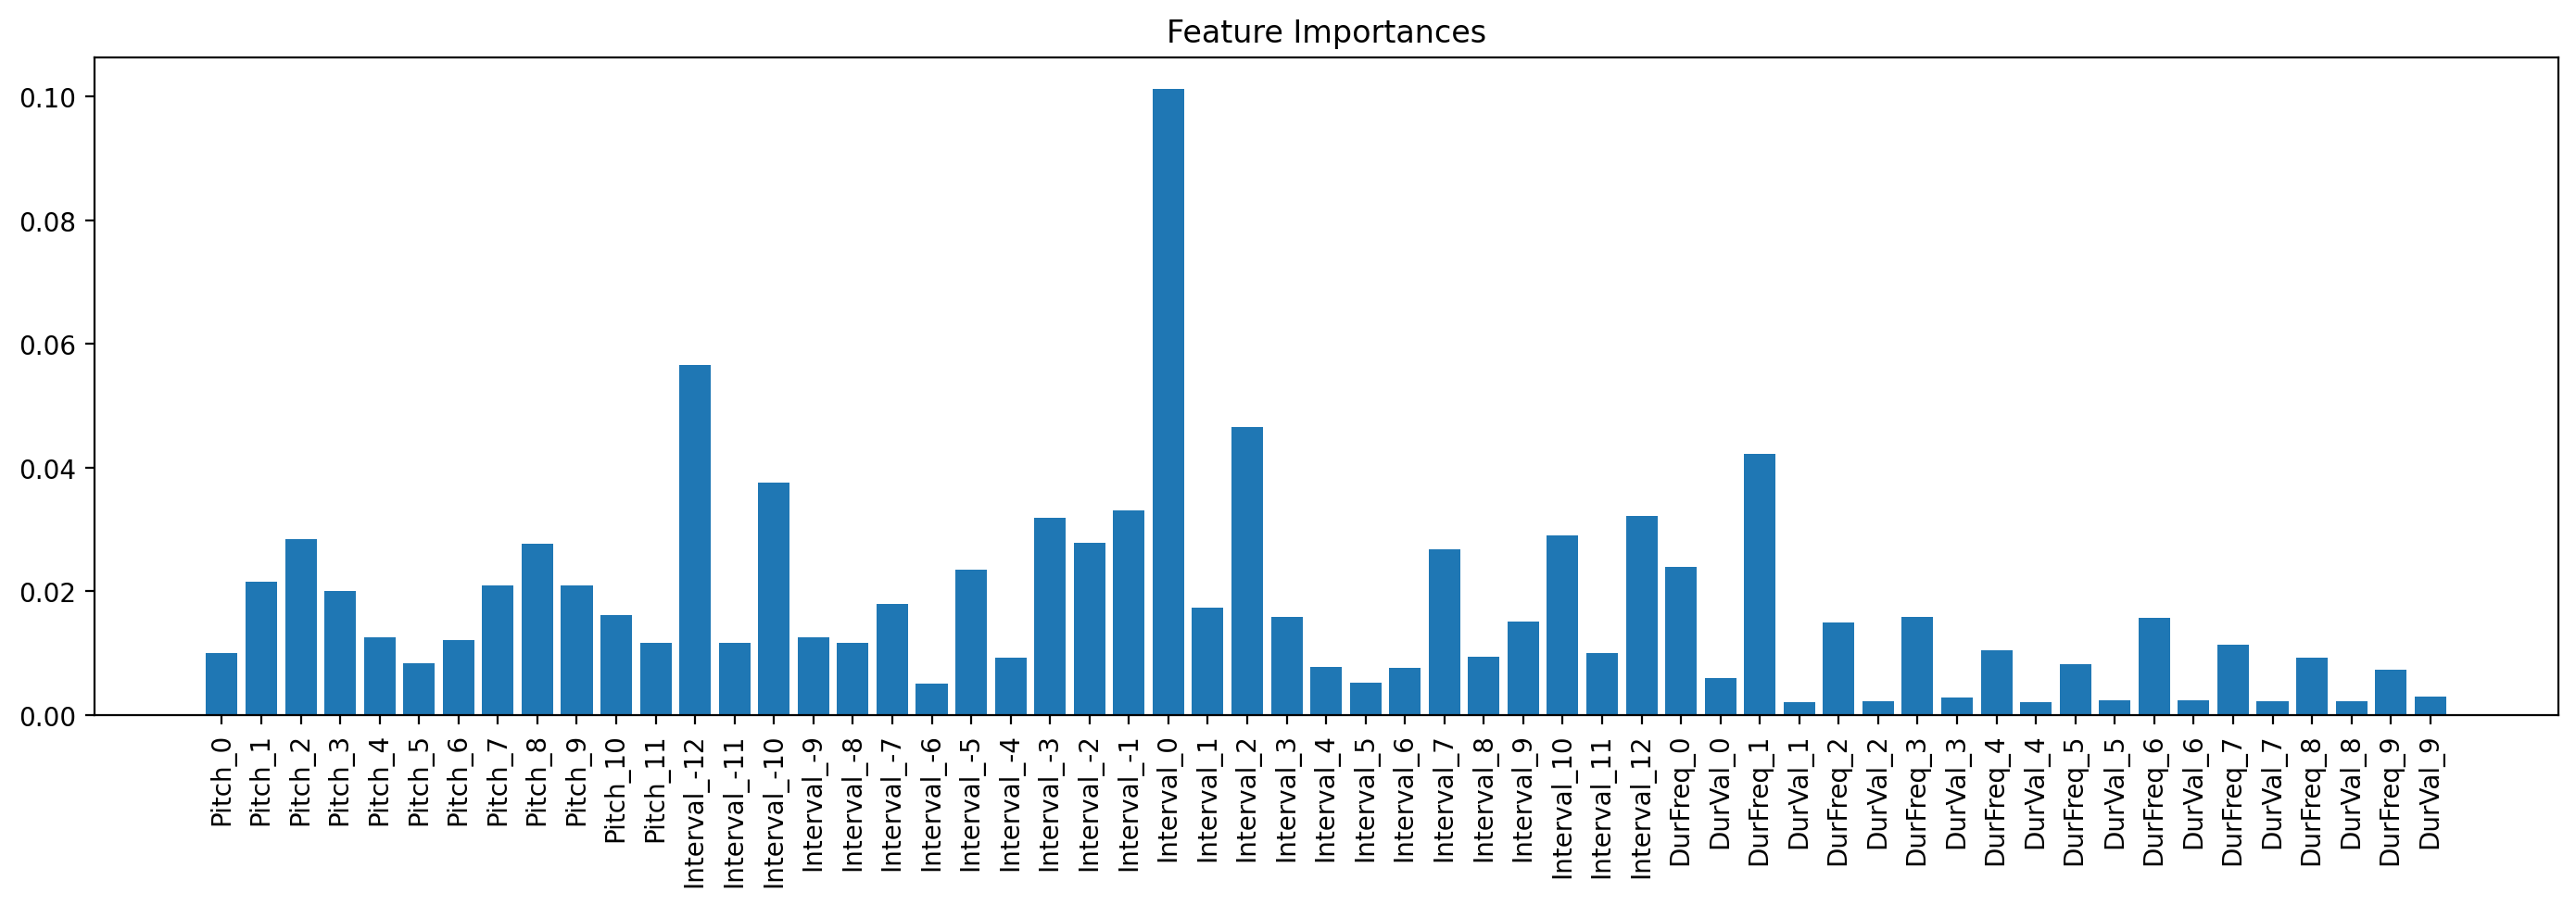

In [ ]:
# Plot all the feature importances
plt.figure(figsize=(14, 5))
plt.bar(feature_labels, feature_importances)
plt.xticks(rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()